In [25]:
from ctypes import *
import time
from sys import path
from os import sep
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

dwf = cdll.LoadLibrary("libdwf.so")
constants_path = "/usr/share/digilent/waveforms/samples/py"
path.append(constants_path)
import dwfconstants as constants

In [26]:
dwf.FDwfDeviceCloseAll()
filter_flags = c_int(constants.enumfilterType.value | constants.enumfilterUSB.value)
device_count = c_int()
dwf.FDwfEnum(filter_flags, byref(device_count))

hdwf = c_int()
dwf.FDwfDeviceOpen(c_int(-1), byref(hdwf))
if hdwf.value == 0:
    raise RuntimeError("Failed to open device.")
print(hdwf.value)

dwf.FDwfAnalogIOReset(hdwf)
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(1), c_double(3.0)) #setting VDD = 3V
dwf.FDwfAnalogIOChannelNodeSet(hdwf, c_int(0), c_int(0), c_double(1))
dwf.FDwfAnalogIOEnableSet(hdwf, c_int(1))
time.sleep(0.5)

vpos = c_double()
dwf.FDwfAnalogIOStatus(hdwf)
dwf.FDwfAnalogIOChannelNodeStatus(hdwf, c_int(0), c_int(1), byref(vpos))
print(f"Power: +{vpos.value:.2f}V")

1
Power: +3.00V


In [27]:
DEVICE_ADDR = 0x52
ENABLE_REG = 0x80
ATIME_REG = 0x81
WTIME_REG = 0x83
CONTROL_REG = 0x8F
CDATAL_REG = 0x94
CDATAH_REG = 0x95
RDATAL_REG = 0x96
RDATAH_REG = 0x97
GDATAL_REG = 0x98
GDATAH_REG = 0x99
BDATAL_REG = 0x9A
BDATAH_REG = 0x9B

def write_register(reg, value):
    iNak = c_int()
    rgTX = (c_ubyte * 2)(reg, value)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(2), byref(iNak))
    return iNak.value == 0

def read_register(reg):
    iNak = c_int()
    rgTX = (c_ubyte * 1)(reg)
    dwf.FDwfDigitalI2cWrite(hdwf, c_int(DEVICE_ADDR), rgTX, c_int(1), byref(iNak))
    if iNak.value == 0:
        rgRX = (c_ubyte * 1)()
        dwf.FDwfDigitalI2cRead(hdwf, c_int(DEVICE_ADDR), rgRX, c_int(1), byref(iNak))
        if iNak.value == 0:
            return rgRX[0]
    return None

dwf.FDwfDigitalI2cRateSet(hdwf, c_double(100e3))
dwf.FDwfDigitalI2cSclSet(hdwf, c_int(0))
dwf.FDwfDigitalI2cSdaSet(hdwf, c_int(1))
iNak = c_int()
dwf.FDwfDigitalI2cClear(hdwf, byref(iNak))

1

In [28]:
write_register(ENABLE_REG, 0x01) #Power on / PON = 1
time.sleep(0.01)
write_register(ENABLE_REG, 0x0B) #Now, also RGBC enable / PON = 1, AEN = 1, WEN = 1
write_register(ATIME_REG, 0xF6) #To run for 24ms, upto a max count of 10,240
write_register(CONTROL_REG, 0x02) #Setting AGAIN=16
write_register(WTIME_REG, 0XFF) #Reseting the wtime register

True

In [29]:
#Function to test the sensor output
def read_colors():
    time.sleep(0.1)
    
    clear_low = read_register(CDATAL_REG)
    clear_high = read_register(CDATAH_REG)
    red_low = read_register(RDATAL_REG)
    red_high = read_register(RDATAH_REG)
    green_low = read_register(GDATAL_REG)
    green_high = read_register(GDATAH_REG)
    blue_low = read_register(BDATAL_REG)
    blue_high = read_register(BDATAH_REG)
    
    if all(val is not None for val in [clear_low, clear_high, red_low, red_high, green_low, green_high, blue_low, blue_high]):
        clear = (clear_high << 8) | clear_low
        red = (red_high << 8) | red_low
        green = (green_high << 8) | green_low
        blue = (blue_high << 8) | blue_low
        return {'clear': clear, 'red': red, 'green': green, 'blue': blue}
    return None

In [30]:
def cleanup():
    dwf.FDwfDeviceClose(hdwf)

In [39]:
cleanup()
#call it everytime after work is done

In [35]:
print("--- Part 1: Data Collection (Jitter vs Gain) ---")

# Set Fixed ATIME (~101ms) for fair comparison
fixed_atime = 0xD5 
write_register(ATIME_REG, fixed_atime)
integ_ms = (256 - fixed_atime) * 2.4

# Define Gains
gains = {0x00: 1, 0x01: 4, 0x02: 16, 0x03: 64}
results_gain = []

print(f"Fixed Time: {integ_ms:.1f}ms. Collecting 100 samples per Gain...")

# 2. SWEEP LOOP
for reg, mult in gains.items():
    write_register(CONTROL_REG, reg)
    time.sleep(0.2) # Stabilize
    
    samples = []
    # Collect 100 samples
    for i in range(100):
        c = read_colors()
        if i%10==0: print(f"GAIN = {mult}, Clear = {c['clear']}, Red = {c['red']}, Green = {c['green']}, Blue = {c['blue']}")
        if c: samples.append(c['clear'])
        time.sleep(0.005) # Small buffer
        
    # Calculate Stats
    if samples:
        mean = np.mean(samples)
        std = np.std(samples)
        jitter_pct = (std / mean * 100) if mean > 0 else 0
        
        print(f"  Gain {mult:2d}x: Mean={mean:7.1f} | StdDev={std:5.2f} | Jitter={jitter_pct:5.3f}%")
        print('\n'+"="*40)
        results_gain.append({'Gain': mult, 'Mean': mean, 'StdDev': std, 'Jitter_Pct': jitter_pct})

print("Part 1 Complete.")

--- Part 1: Data Collection (Jitter vs Gain) ---
Fixed Time: 103.2ms. Collecting 100 samples per Gain...
GAIN = 1, Clear = 283, Red = 86, Green = 105, Blue = 91
GAIN = 1, Clear = 281, Red = 86, Green = 105, Blue = 91
GAIN = 1, Clear = 284, Red = 86, Green = 105, Blue = 92
GAIN = 1, Clear = 285, Red = 87, Green = 106, Blue = 92
GAIN = 1, Clear = 283, Red = 86, Green = 105, Blue = 92
GAIN = 1, Clear = 281, Red = 86, Green = 105, Blue = 91
GAIN = 1, Clear = 282, Red = 86, Green = 105, Blue = 92
GAIN = 1, Clear = 285, Red = 87, Green = 106, Blue = 92
GAIN = 1, Clear = 283, Red = 86, Green = 105, Blue = 92
GAIN = 1, Clear = 281, Red = 86, Green = 105, Blue = 91
  Gain  1x: Mean=  282.9 | StdDev= 1.46 | Jitter=0.518%

GAIN = 4, Clear = 1106, Red = 337, Green = 413, Blue = 357
GAIN = 4, Clear = 1117, Red = 340, Green = 416, Blue = 360
GAIN = 4, Clear = 1121, Red = 341, Green = 418, Blue = 361
GAIN = 4, Clear = 1114, Red = 339, Green = 415, Blue = 359
GAIN = 4, Clear = 1106, Red = 337, Green =

In [37]:
print("--- Part 2: Data Collection (Jitter vs ATIME) ---")

# 1. SETUP
# Set Fixed Gain to 64x (0x03) to ensure noise is visible
fixed_gain_reg = 0x03 
write_register(CONTROL_REG, fixed_gain_reg)

# Define ATIME Steps: 2.4ms, 24ms, 101ms, 154ms, 614ms
atime_steps = [0xFF, 0xF6, 0xD5, 0xC0, 0x00]
results_time = []

print(f"Fixed Gain: 60x. Collecting 100 samples per ATIME...")

# 2. SWEEP LOOP
for atime_val in atime_steps:
    write_register(ATIME_REG, atime_val)
    
    # Calculate necessary wait per sample
    time_ms = (256 - atime_val) * 2.4
    wait_sec = (time_ms / 1000.0) + 0.01
    
    samples = []
    # Collect 100 samples
    for _ in range(100):
        time.sleep(wait_sec) # Must wait for integration cycle
        c = read_colors()
        if _ % 10 == 0: print(f"ATIME = {255 - atime_val}, Clear = {c['clear']}, Red = {c['red']}, Green = {c['green']}, Blue = {c['blue']}")
        if c: samples.append(c['clear'])
        
    # Calculate Stats
    if samples:
        mean = np.mean(samples)
        std = np.std(samples)
        jitter_pct = (std / mean * 100) if mean > 0 else 0
        
        print(f"  Time {time_ms:5.1f}ms: Mean={mean:7.1f} | StdDev={std:5.2f} | Jitter={jitter_pct:5.3f}%")
        print("\n"+"="*40)
        results_time.append({'Time_ms': time_ms, 'Mean': mean, 'StdDev': std, 'Jitter_Pct': jitter_pct})

print("Part 2 Complete.")

--- Part 2: Data Collection (Jitter vs ATIME) ---
Fixed Gain: 60x. Collecting 100 samples per ATIME...
ATIME = 0, Clear = 411, Red = 145, Green = 180, Blue = 124
ATIME = 0, Clear = 424, Red = 129, Green = 180, Blue = 120
ATIME = 0, Clear = 313, Red = 132, Green = 178, Blue = 152
ATIME = 0, Clear = 320, Red = 101, Green = 168, Blue = 150
ATIME = 0, Clear = 332, Red = 104, Green = 172, Blue = 146
ATIME = 0, Clear = 344, Red = 107, Green = 176, Blue = 143
ATIME = 0, Clear = 357, Red = 110, Green = 178, Blue = 139
ATIME = 0, Clear = 370, Red = 114, Green = 179, Blue = 136
ATIME = 0, Clear = 484, Red = 145, Green = 154, Blue = 101
ATIME = 0, Clear = 485, Red = 145, Green = 151, Blue = 101
  Time   2.4ms: Mean=  398.0 | StdDev=62.35 | Jitter=15.667%

ATIME = 9, Clear = 3902, Red = 1199, Green = 1467, Blue = 1254
ATIME = 9, Clear = 4059, Red = 1249, Green = 1535, Blue = 1316
ATIME = 9, Clear = 3933, Red = 1207, Green = 1479, Blue = 1269
ATIME = 9, Clear = 4029, Red = 1233, Green = 1513, Blue 

--- Part 3: Plotting Analysis ---


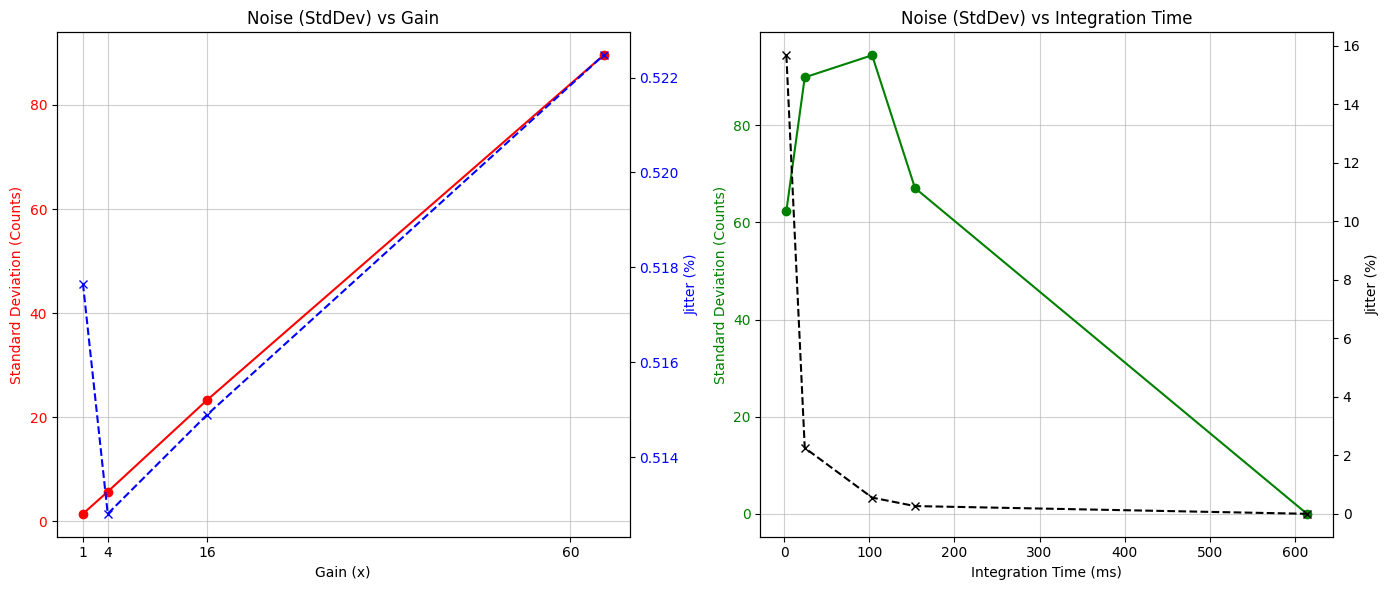

In [ ]:
print("--- Part 3: Plotting Analysis ---")

# Convert lists to DataFrames
df_gain = pd.DataFrame(results_gain)
df_time = pd.DataFrame(results_time)

# Create 2 Subplots side-by-side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- PLOT 1: Noise vs Gain ---
# Primary Axis: Absolute Noise (Std Dev)
ax1.plot(df_gain['Gain'], df_gain['StdDev'], 'r-o', label='Absolute Noise (Counts)')
ax1.set_title('Noise (StdDev) vs Gain')
ax1.set_xlabel('Gain (x)')
ax1.set_ylabel('Standard Deviation (Counts)', color='red')
ax1.tick_params(axis='y', labelcolor='red')
ax1.set_xticks([1, 4, 16, 60])
ax1.grid(True, alpha=0.6)

# Secondary Axis: Jitter Percentage
ax1b = ax1.twinx()
ax1b.plot(df_gain['Gain'], df_gain['Jitter_Pct'], 'b--x', label='Jitter %')
ax1b.set_ylabel('Jitter (%)', color='blue')
ax1b.tick_params(axis='y', labelcolor='blue')

# --- PLOT 2: Noise vs Integration Time ---
# Primary Axis: Absolute Noise (Std Dev)
ax2.plot(df_time['Time_ms'], df_time['StdDev'], 'g-o', label='Absolute Noise (Counts)')
ax2.set_title('Noise (StdDev) vs Integration Time')
ax2.set_xlabel('Integration Time (ms)')
ax2.set_ylabel('Standard Deviation (Counts)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.grid(True, alpha=0.6)

# Secondary Axis: Jitter Percentage
ax2b = ax2.twinx()
ax2b.plot(df_time['Time_ms'], df_time['Jitter_Pct'], 'k--x', label='Jitter %')
ax2b.set_ylabel('Jitter (%)', color='black')
ax2b.tick_params(axis='y', labelcolor='black')

plt.tight_layout()
plt.show()  